In [1]:
import torch
import gpytorch
import random
from gpytorch.likelihoods import GaussianLikelihood, DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
import numpy as np
from alse.eci import ExpectedCoverageImprovement
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints
from alse.fit_model import fit_gp_class, fit_gp_reg
from alse.fit_all_demo_only import fit_all_models

In [2]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

Define Necessary functions

In [3]:
def hills(x):
    v = 0.5*torch.cos(x[:,0]*2-torch.pi)+torch.sin(x[:,1]+torch.pi/2)
    
    return v.unsqueeze(-1)
    
def circle(x):
    v = -(x[:,0] ** 2 + x[:,1] ** 2) + 25
    return v.unsqueeze(-1)

def yf(x):
    v = (((x[:,0]**2+x[:,1]-11)**2+(x[:,0]+x[:,1]**2-7)**2)>160)
    return v.unsqueeze(-1)

def get_rand_coord(num_rand_points):
    a = 6*torch.rand(num_rand_points)-3
    b = 6*torch.rand(num_rand_points)-3
    return torch.stack((a,b),-1)

def get_grid_coord(N):
    X, Y = torch.meshgrid(
    torch.linspace(-3, 3, N, **tkwargs), torch.linspace(-3, 3, N, **tkwargs),
    indexing='xy',)
    return torch.stack(
        (
            torch.reshape(X, (X.shape[0] * X.shape[1],)),
            torch.reshape(Y, (Y.shape[0] * Y.shape[1],)),
        ),
        dim=1,
    )

Grid of N1xN2 for plotting

In [4]:
N1, N2 = 150, 150
X, Y = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs),
    indexing='xy',
)
x = torch.stack(
    (
        torch.reshape(X, (X.shape[0] * X.shape[1],)),
        torch.reshape(Y, (Y.shape[0] * Y.shape[1],)),
    ),
    dim=1,
)

In bound points would be set to 1, else 0

In [5]:
Y_hills = (hills(x) > 0.3).reshape(N1, N2)
Y_circle = (circle(x) > 20).reshape(N1, N2)
Y_yf = yf(x).reshape(N1, N2)

reference = (Y_hills & Y_circle & Y_yf)

Created a model from random data

In [6]:
num_rand_points = 5

In [7]:
rand_x = get_grid_coord(num_rand_points)
rand_y_hills = hills(rand_x)
rand_y_circle = circle(rand_x)
rand_y_class = yf(rand_x)

Fit a model based on these points

In [8]:
predicted_hills, predicted_circle, predicted_yf = fit_all_models(x, N1, N2, rand_x, rand_y_hills, rand_y_circle, rand_y_class)

c:\Program Files\Python310\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Plot model 1

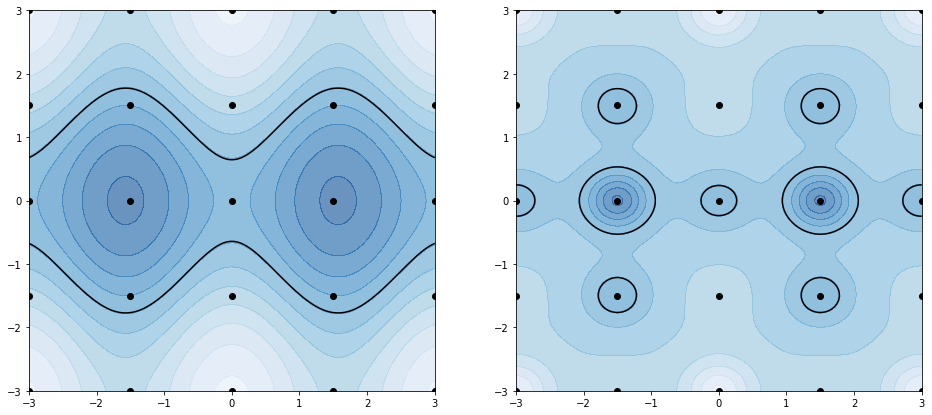

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, hills(x).reshape(N1,N2), levels=torch.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].plot(rand_x[:,0], rand_x[:,1], "ko")
ax[0].contour(X, Y, hills(x).reshape(N1,N2), [0.3, 2], colors="k")
ax[1].contourf(X, Y, predicted_hills.detach(), levels=torch.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, predicted_hills.detach(), [0.3, 2], colors="k")
ax[1].plot(rand_x[:,0], rand_x[:,1], "ko")

Plot model 2

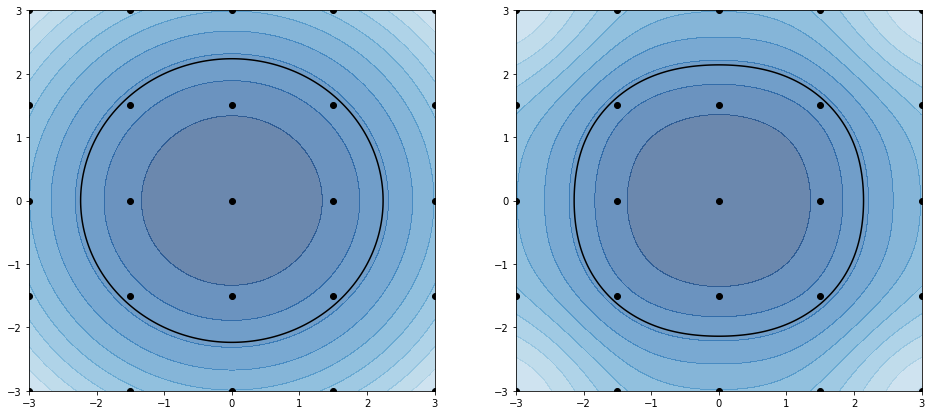

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, circle(x).reshape(N1,N2), levels=torch.linspace(0, 25, 15), cmap="Blues", alpha=0.6)
ax[0].contour(X, Y, circle(x).reshape(N1,N2), [20, 30], colors="k")
ax[0].plot(rand_x[:,0], rand_x[:,1], "ko")
ax[1].contourf(X, Y, predicted_circle.detach(), levels=torch.linspace(0, 25, 15), cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, predicted_circle.detach(), [20, 30], colors="k")
ax[1].plot(rand_x[:,0], rand_x[:,1], "ko")

Plot model 3

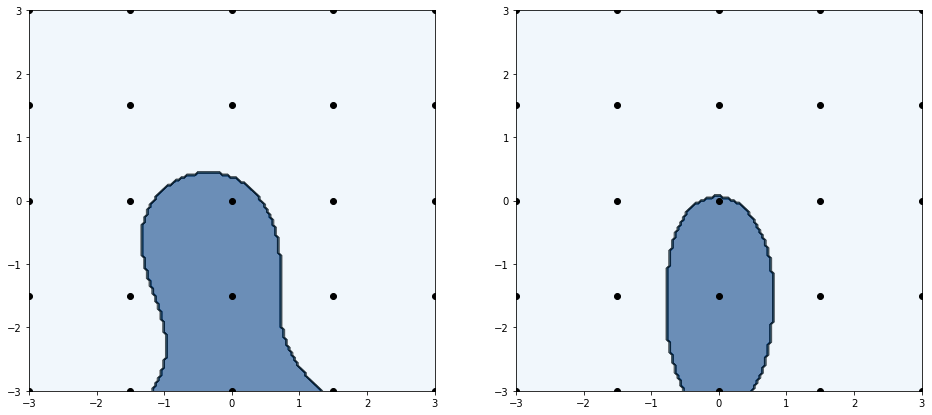

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, yf(x).reshape(N1,N2), cmap="Blues", alpha=0.6)
ax[0].contour(X, Y, yf(x).reshape(N1,N2), linewidths=0.3, colors="k")
ax[0].plot(rand_x[:,0], rand_x[:,1], "ko")
ax[1].contourf(X.cpu(), Y.cpu(), predicted_yf, cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, predicted_yf, linewidths=0.3, colors="k")
ax[1].plot(rand_x[:,0], rand_x[:,1], "ko")

Text(0.5, 1.0, 'Estimated boundary')

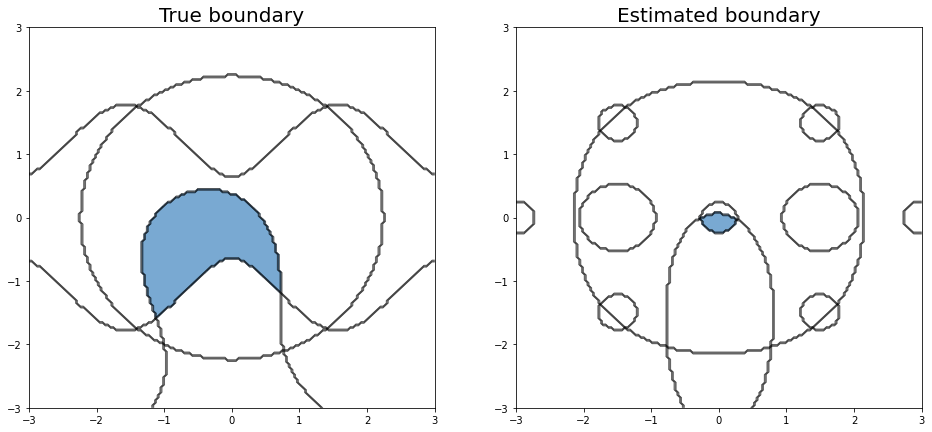

In [12]:
est_overlap = (predicted_circle > 20) & (predicted_hills > 0.3) & predicted_yf

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(X, Y, reference, levels=torch.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[0].contour(X, Y, Y_hills, linewidths=0.3, colors="k")
ax[0].contour(X, Y, Y_circle, linewidths=0.3, colors="k")
ax[0].contour(X, Y, Y_yf, linewidths=0.3, colors="k")
ax[0].set_title("True boundary", fontsize=20)


ax[1].contourf(X, Y, est_overlap, levels=torch.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[1].contour(X, Y, (predicted_hills > 0.3), linewidths=0.3, colors="k")
ax[1].contour(X, Y, (predicted_circle > 20), linewidths=0.3, colors="k")
ax[1].contour(X, Y, predicted_yf, linewidths=0.3, colors="k")
ax[1].set_title("Estimated boundary", fontsize=20)

In [13]:
est_overlap = (predicted_circle > 20) & (predicted_hills > 0.3) & predicted_yf

get_accuracy(est_overlap, reference)

Accuracy of this run: 0.0477,
 Reward: 71 
 Penalty: 0


In [14]:
def test_rand():
    raw = torch.tensor([0])
    for i in range(500):
        rand_x = get_rand_coord(50)
        predicted_hills, predicted_circle, predicted_yf = fit_all_models(rand_x, hills(rand_x), circle(rand_x), yf(rand_x))

        est_overlap = (predicted_circle > 20) & (predicted_hills > 0.3) & predicted_yf
        a = (est_overlap & reference)
        accuracy = torch.tensor([round(float(a.sum()/reference.sum()), 4)])
        raw = torch.cat((raw, accuracy),0)
    #Return everything after the intial zero
    return raw[1:]

In [15]:
# trial = test_rand()


In [16]:
# trial.mean()